#### Imports

In [5]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

## Filtering and Combining Desired Reviews

In [6]:
# Load the combined reviews data from the saved file
combined_reviews_df = pd.read_csv('processed_data/combined_reviews.csv', encoding='utf-8', engine='python')

# Filter the reviews with 4 and 5 stars
frequent_items_reviews = combined_reviews_df[combined_reviews_df['rating'].isin([4, 5])]

# Load the positive reviews from the sentiment analysis on the 3-star reviews
positive_reviews_df = pd.read_csv('processed_data/3_star_positive_reviews.csv', encoding='utf-8', engine='python')

# Combine the filtered 4 and 5-star reviews with the 3-star positive reviews
frequent_items_reviews = pd.concat([frequent_items_reviews, positive_reviews_df], ignore_index=True)

print(f"Total reviews to be used in frequent items: {len(frequent_items_reviews)}")

Total reviews to be used in frequent items: 693706


In [7]:
# Check how many unique products there are based on 'product_id'
unique_products_count = frequent_items_reviews['product_id'].nunique()

# Pretty printing the result
print(f"Total number of unique products in the reviews dataset: {unique_products_count}")

Total number of unique products in the reviews dataset: 1547


## Frequent Items

Users per group:
2+ reviews: 117478 users
3+ reviews: 55381 users
4+ reviews: 30713 users
5+ reviews: 18762 users
6+ reviews: 12562 users
7+ reviews: 9012 users
8+ reviews: 6902 users
9+ reviews: 5535 users
10+ reviews: 4614 users
20+ reviews: 1575 users
30+ reviews: 825 users
40+ reviews: 458 users
50+ reviews: 256 users
60+ reviews: 138 users
70+ reviews: 77 users
80+ reviews: 34 users
90+ reviews: 13 users
100+ reviews: 7 users
110+ reviews: 6 users
120+ reviews: 4 users
130+ reviews: 2 users
140+ reviews: 1 users
150+ reviews: 1 users
160+ reviews: 1 users
170+ reviews: 1 users
180+ reviews: 1 users
190+ reviews: 1 users
200+ reviews: 1 users
210+ reviews: 0 users


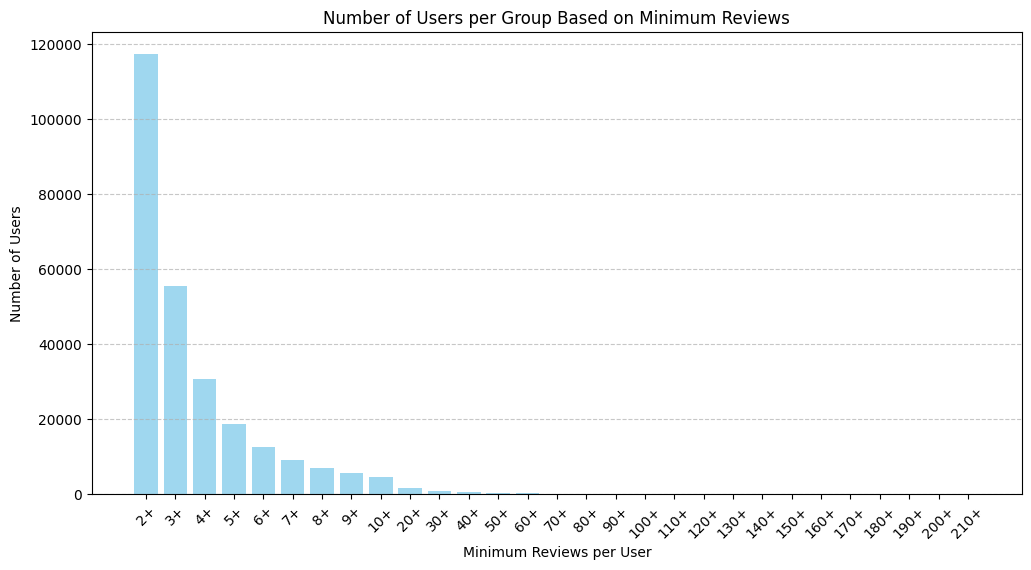

In [8]:
# Step 1: Aggregate reviews by user
user_review_counts = frequent_items_reviews.groupby('author_id')['product_id'].nunique()

# Step 2: Define thresholds for grouping
thresholds = list(range(2, 11)) + [20, 30] + list(range(40, user_review_counts.max() + 10, 10))

# Step 3: Count users per group
users_per_group = []

for t in thresholds:
    count = (user_review_counts >= t).sum()
    users_per_group.append(count)

# Step 4: Display results
print("Users per group:")
for t, count in zip(thresholds, users_per_group):
    print(f"{t}+ reviews: {count} users")

plt.figure(figsize=(12, 6))
plt.bar([str(t) + "+" for t in thresholds], users_per_group, color="skyblue", alpha=0.8)
plt.title("Number of Users per Group Based on Minimum Reviews")
plt.xlabel("Minimum Reviews per User")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

_____

In [9]:
# Selecting users with 10+ reviews
filtered_df = frequent_items_reviews.groupby('author_id').filter(lambda x: x['product_id'].nunique() > 9)

# Display the filtered DataFrame
print(f"Number of rows in the filtered dataframe: {len(filtered_df)}")
print(f"Number of unique authors in the filtered dataframe: {len(set(filtered_df['author_id']))}")
#set(filtered_df['author_id'])

Number of rows in the filtered dataframe: 95912
Number of unique authors in the filtered dataframe: 4614


In [10]:
# Combining all the products reviewed for each person in the dataset
selected_columns = filtered_df[['author_id', 'product_id']]

# Convert product_id to string before applying 'join'
combined_reviews = selected_columns.groupby('author_id')['product_id'].apply(lambda x: ' '.join(x.astype(str))).reset_index()

print(combined_reviews)

            author_id                                         product_id
0          1000235057  P420652 P421275 P297524 P456412 P232903 P37584...
1         10003868106  P420652 P480612 P375849 P375853 P472468 P37585...
2          1001087549  P309308 P423688 P270594 P433520 P232915 P45621...
3         10015807972  P420652 P427419 P454380 P480612 P427406 P42741...
4         10021044780  P309308 P442840 P466123 P500633 P418346 P47641...
...               ...                                                ...
4609        998162812  P269122 P429952 P471237 P443833 P422022 P37970...
4610        998179876  P309308 P429952 P270594 P442840 P466123 P44779...
4611        998853649  P456398 P461159 P461933 P456213 P429242 P41561...
4612       9990263118  P430337 P427406 P431180 P440307 P410400 P45567...
4613  orderGen1698648  P443833 P428095 P455926 P502656 P446423 P45536...

[4614 rows x 2 columns]


In [11]:
# Convert the 'reviews' into a list of transactions
transactions = combined_reviews['product_id'].str.split().tolist()

# Create a DataFrame for one-hot encoding
# Flatten all unique items (reviews) and create a unique item list
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# Apply the Apriori algorithm
frequent_itemsets = apriori(df_encoded, min_support=0.03, use_colnames=True)

# Focus on frequent itemsets containing only a single product (not pairs or larger sets)
frequent_pairs = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) == 1]

# Generate association rules, with support as minimum of 3%
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.03, num_itemsets=len(frequent_itemsets))

print(frequent_pairs)

      support   itemsets
0    0.076940  (P232915)
1    0.053099  (P269122)
2    0.263329  (P270594)
3    0.183138  (P309308)
4    0.040312  (P379707)
..        ...        ...
190  0.047898  (P505049)
191  0.069571  (P505054)
192  0.036628  (P505139)
193  0.031209  (P505158)
194  0.033810    (P7880)

[195 rows x 2 columns]


In [12]:
# Filter rules to include only those where antecedents have a single item
rules_filtered = rules[rules['antecedents'].apply(len) == 1].copy()

rules_display = rules_filtered[["antecedents", "consequents", "support", "confidence", "lift"]].copy()

# Convert frozensets to readable strings
rules_display["antecedents"] = rules_display["antecedents"].apply(lambda x: ', '.join(list(x)))
rules_display["consequents"] = rules_display["consequents"].apply(lambda x: ', '.join(list(x)))

# Sorting by confidence
rules_display = rules_display.sort_values(by="support", ascending=False)
print(rules_display.to_string(index=False))

antecedents               consequents  support  confidence      lift
    P500633                   P270594 0.148244    0.524138  1.990430
    P270594                   P500633 0.148244    0.562963  1.990430
    P500633                   P503936 0.127221    0.449808  2.109163
    P503936                   P500633 0.127221    0.596545  2.109163
    P270594                   P503936 0.122237    0.464198  2.176634
    P503936                   P270594 0.122237    0.573171  2.176634
    P500633                   P476414 0.113784    0.402299  1.878752
    P476414                   P500633 0.113784    0.531377  1.878752
    P476414                   P270594 0.110750    0.517206  1.964108
    P270594                   P476414 0.110750    0.420576  1.964108
    P500633                   P500777 0.105982    0.374713  2.394632
    P500777                   P500633 0.105982    0.677285  2.394632
    P500633                   P479841 0.105548    0.373180  2.141608
    P479841                   P500

In [13]:
unique_values = pd.concat([rules_display['antecedents']]).nunique()
unique_values

82

## Testing

In [14]:
filtered_rules = rules_display[rules_display['antecedents'].apply(lambda x: 'P500633' in x)]
print(filtered_rules)

     antecedents       consequents   support  confidence      lift
100      P500633           P270594  0.148244    0.524138  1.990430
880      P500633           P503936  0.127221    0.449808  2.109163
604      P500633           P476414  0.113784    0.402299  1.878752
854      P500633           P500777  0.105982    0.374713  2.394632
734      P500633           P479841  0.105548    0.373180  2.141608
...          ...               ...       ...         ...       ...
1985     P500633  P477157, P479841  0.030342    0.107280  2.379752
2226     P500633  P503668, P503936  0.030342    0.107280  2.334851
877      P500633           P503879  0.030126    0.106513  1.269904
2160     P500633  P482676, P501760  0.030126    0.106513  2.730294
2213     P500633  P501760, P503726  0.030126    0.106513  2.642220

[206 rows x 5 columns]


In [15]:
# Preprocess the rules DataFrame to ensure 'antecedents' and 'consequents' are sets
def preprocess_rules(rules):
   """
   Preprocess the rules DataFrame to ensure 'antecedents' and 'consequents' are sets.
   """
    # Create a copy of the DataFrame to avoid modifying the original
   rules = rules.copy()
   rules['antecedents'] = rules['antecedents'].apply(lambda x: x.split(", ") if isinstance(x, str) else x)
   rules['consequents'] = rules['consequents'].apply(lambda x: x.split(", ") if isinstance(x, str) else x)
   return rules   

# Function to find items associated with an input item
def find_associated_items(input_item, rules):
   """
   Find all items associated with an input item based on association rules.

   Parameters:
      input_item (str): The item to find associations for.
      rules (pd.DataFrame): A DataFrame of association rules with columns 'antecedents' and 'consequents'.

   Returns:
      list: A list of items associated with the input item, preserving the order of rules.
   """
   # Sort rules by confidence in descending order
   rules = rules.sort_values(by='confidence', ascending=False).reset_index(drop=True)

   input_item_antecedents = [input_item]

   associated_items = []
   
   # Iterate through the rules
   for _, rule in rules.iterrows():
      antecedents = rule['antecedents']
      consequents = rule['consequents']
            
      # Check if the input item is in the antecedents
      if input_item_antecedents == antecedents:
         # Add consequents to the associated items if not already present
         for item in consequents:
               if item not in associated_items:
                  associated_items.append(item)
                  
   return associated_items

rules_df = pd.DataFrame(rules_display)

# Preprocess the rules DataFrame
rules_df = preprocess_rules(rules_df)

# Input item
input_item = 'P500633'

# Find associated items
associated_items = find_associated_items(input_item, rules_df)
print(f"Items associated with '{input_item}': {associated_items}")

Items associated with 'P500633': ['P270594', 'P503936', 'P476414', 'P500777', 'P479841', 'P423688', 'P479327', 'P501760', 'P482676', 'P501254', 'P400259', 'P411365', 'P442840', 'P479318', 'P469538', 'P503726', 'P505031', 'P479645', 'P482535', 'P471237', 'P500288', 'P481739', 'P423148', 'P482551', 'P483076', 'P505023', 'P500857', 'P474832', 'P466123', 'P481831', 'P309308', 'P477157', 'P503668', 'P481989', 'P482540', 'P505009', 'P481732', 'P455236', 'P500993', 'P433520', 'P461949', 'P471046', 'P503814', 'P505054', 'P471043', 'P418624', 'P232915', 'P504045', 'P500744', 'P442838', 'P456218', 'P505024', 'P462666', 'P442839', 'P481830', 'P501288', 'P475124', 'P504044', 'P503651', 'P504125', 'P474075', 'P479348', 'P458219', 'P501282', 'P470529', 'P480461', 'P483679', 'P505049', 'P503891', 'P481366', 'P505020', 'P479692', 'P500618', 'P480613', 'P423136', 'P503879']


### Download variables to use in reccomender notebook

In [16]:
rules_display.to_csv('processed_data/association_rules.csv', index=False)